# Plant Traits
We are tasked with building a multi-modal deep-learning model

### 🛠 | Import Libraries and Data

In [24]:
!mkdir -p /root/.kaggle
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [2]:
!kaggle competitions download -c cs-480-2024-spring

100% 287M/287M [00:15<00:00, 21.3MB/s]
100% 287M/287M [00:15<00:00, 19.3MB/s]


In [3]:
!unzip -q cs-480-2024-spring.zip

In [ ]:
!pip install timm
!pip install lightning

### ⚙️ | Configuration

In [2]:
class Config:
    #https://huggingface.co/timm/tf_efficientnetv2_s.in21k
    preset = "timm/tf_efficientnetv2_s.in21k"
    image_size = 300
    epochs = 10
    batch_size = 64
    num_classes = 6
    class_names = ['X4_mean', 'X11_mean', 'X18_mean', 'X26_mean', 'X50_mean', 'X3112_mean']
    num_classes = len(class_names)
    Lower_Quantile = 0.005
    Upper_Quantile = 0.985
    train_val_ratio = 0.8
    weight_decay = 0.098

    # https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7614424/ -> just under 2e-4 seems like a good place after playign around with this
    lr_max = 1.98e-4
    lr_abalation_test = False

Config = Config()

### 📚 | Import Libraries

In [1]:
import os
import numpy as np
import torch
import torchmetrics
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import timm  # Ensure this is installed via pip install timm
from PIL import Image  # Import PIL to handle image conversion
import pandas as pd
import lightning as L
import imageio
import matplotlib.pyplot as plt
# https://pseudo-lab.github.io/Tutorial-Book-en/chapters/en/object-detection/Ch3-preprocessing.html -> recommended to use this over torchvision
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import torchmetrics
import time
from tqdm.notebook import tqdm
from torchsummary import summary

Use GPU and set randomization seed for reproducibility

In [3]:
# referenced from cs480 Assignment 3
# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

if device == torch.device("cuda:0"):
  print('Everything looks good; continue')
else:
  # It is OK if you cannot connect to a GPU. In this case, training the model for
  # 5 epoch is sufficient to get full mark.
  print('GPU is not detected. Make sure you have chosen the right runtime type')

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Everything looks good; continue


### 📁 | Data Processing

In [4]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

Remove outliers in the data, we'll use quantiles to detect this:

In [5]:
for column in Config.class_names:
    lower_quantile = train_data[column].quantile(Config.Lower_Quantile)
    upper_quantile = train_data[column].quantile(Config.Upper_Quantile)
    train_data = train_data[(train_data[column] >= lower_quantile) & (train_data[column] <= upper_quantile)]

Let's explore our dataset a bit more:

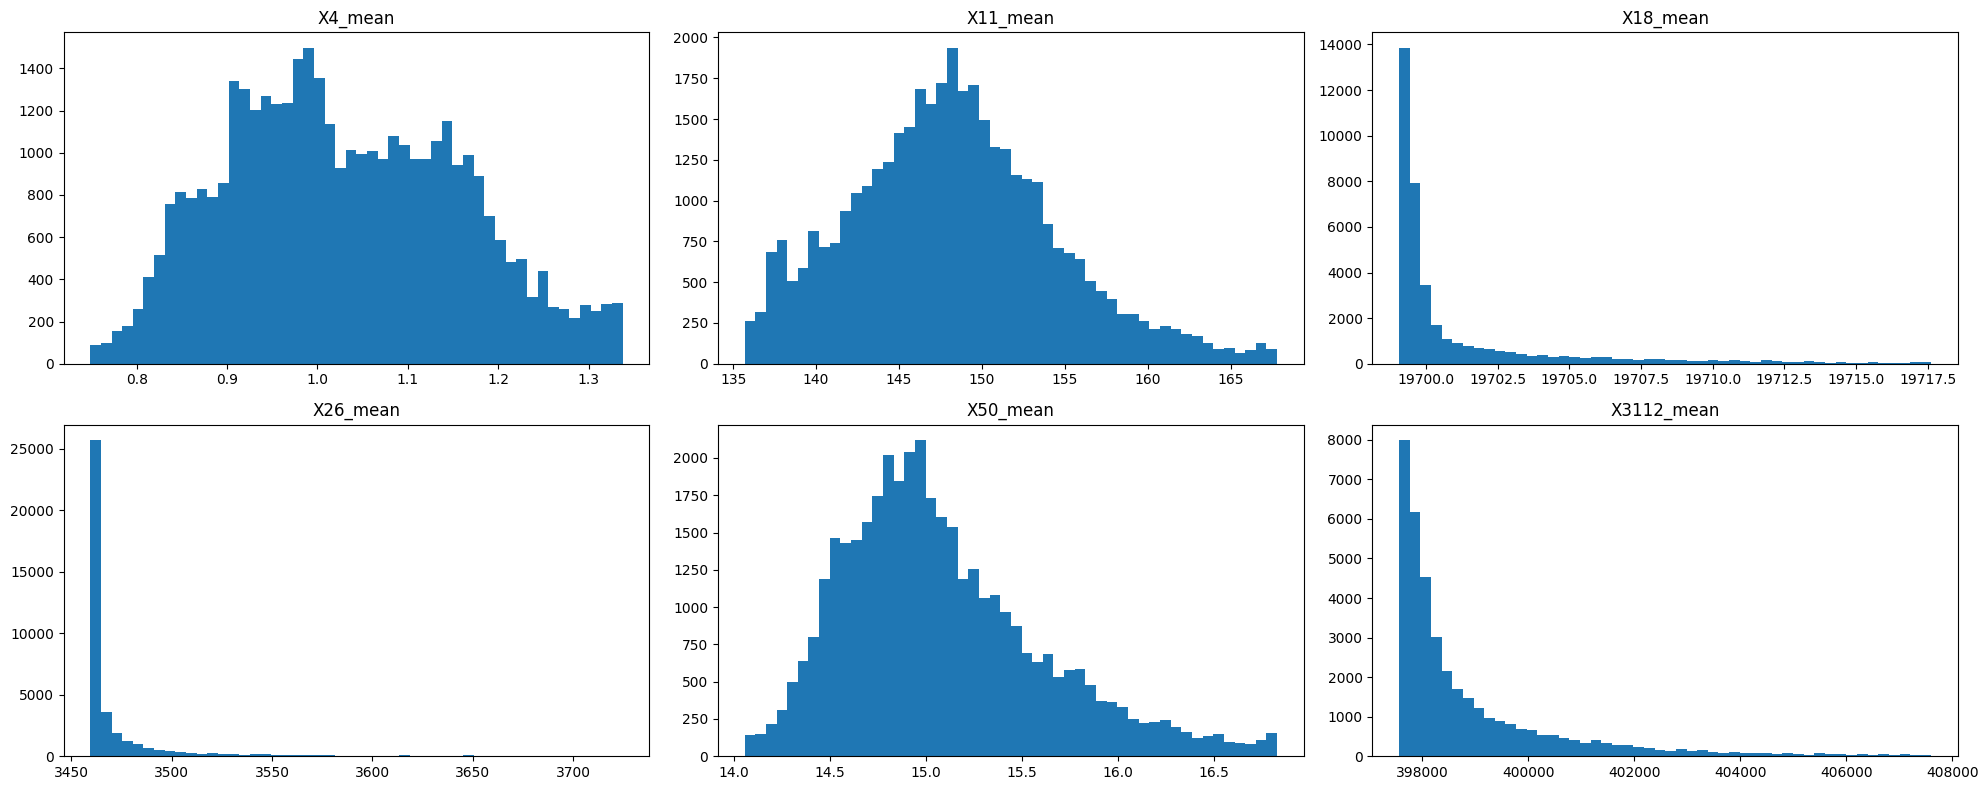

In [7]:
n_cols = 3
n_rows = int(np.ceil(len(Config.class_names) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for i, column in enumerate(Config.class_names):
    if column in train_data.columns:
        axes[i].hist(train_data[column], bins=50)
        axes[i].set_title(f"{column}")

for j in range(len(Config.class_names), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In general, these 6 fatures have a right-skewed distribution, where most of the data points are concentrated on the left side with a long tail. So, let's take the log of these to scale it better:

In [8]:
aux_train_tabular = train_data.drop(columns=['id'] + Config.class_names)
aux_test_tabular = test_data.drop(columns=['id'])

y_train = np.zeros_like(train_data[Config.class_names], dtype=np.float32)
for target_idx, target in enumerate(Config.class_names):
    v = train_data[target].values
    if target in Config.class_names:  # Fix the condition to check against class_names, not train_data[Config.class_names]
        v = np.log10(v)
    y_train[:, target_idx] = v


X_SCALER = StandardScaler()
aux_train_tabular_scaled = X_SCALER.fit_transform(aux_train_tabular).astype(np.float32)
aux_test_tabular_scaled = X_SCALER.transform(aux_test_tabular).astype(np.float32)

Y_SCALER = StandardScaler()
y_train_scaled = Y_SCALER.fit_transform(y_train).astype(np.float32)

# this was used following the Schiller paper, did not yield good results comparable to standard scaler
# X_SCALER = MinMaxScaler()
# aux_train_tabular_scaled = X_SCALER.fit_transform(aux_train_tabular).astype(np.float32)
# aux_test_tabular_scaled = X_SCALER.transform(aux_test_tabular).astype(np.float32)

# Y_SCALER = MinMaxScaler()
# y_train_scaled = Y_SCALER.fit_transform(y_train).astype(np.float32)

Let's save our images into DataFrames for better manipulation, and merge them into one set with the tabular set:

In [9]:
def augment_dataframe(data, id_column, base_dir, sub_dir):
    def get_file_path(file_id):
        return os.path.join(base_dir, sub_dir, f'{file_id}.jpeg')

    def read_jpeg_data(file_path):
        with open(file_path, 'rb') as f:
            return f.read()

    data['file_path'] = data[id_column].apply(get_file_path)
    data['data'] = data['file_path'].apply(read_jpeg_data)

    return data

train_data = augment_dataframe(train_data, 'id', './data', 'train_images')
test_data = augment_dataframe(test_data, 'id', './data', 'test_images')

In [10]:
#https://discuss.pytorch.org/t/discussion-why-normalise-according-to-imagenet-mean-and-std-dev-for-transfer-learning/115670
# https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

# we use these as image backbone was trained on this
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Transformations
training_transformation_pipeline = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Resize(Config.image_size, Config.image_size),
    A.RandomSizedCrop(min_max_height=(150, 300), height=Config.image_size, width=Config.image_size, w2h_ratio=1.0, p=0.75),
    A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.25),
    A.ImageCompression(quality_lower=85, quality_upper=100, p=0.25),
    A.ToFloat(),
    A.Normalize(mean=imagenet_mean, std=imagenet_std, max_pixel_value=1),
    ToTensorV2(),
])


test_transformation_pipeline = A.Compose([
    A.Resize(Config.image_size, Config.image_size),
    A.ToFloat(),
    A.Normalize(mean=imagenet_mean, std=imagenet_std, max_pixel_value=1),
    ToTensorV2(),
])

In [11]:
# Split Train and Val data with set ration in config
train_images, val_images, train_tabular, val_tabular, train_y, val_y = train_test_split(
    train_data['data'].values,
    aux_train_tabular_scaled,
    y_train_scaled,
    train_size=Config.train_val_ratio,
    random_state=42
)

test_images = test_data['data'].values
test_tabular = aux_test_tabular_scaled

### 🍚 | DataLoader

In [12]:
# referenced: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
class MultimodalDataset(data.Dataset):
    def __init__(self, image_data, tabular_data, labels, transform=None):
        self.image_data = image_data
        self.tabular_data = tabular_data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image_sample = imageio.imread(self.image_data[index])
        if self.transform:
            image_sample = self.transform(image=image_sample)['image']
        tabular_sample = self.tabular_data[index]
        label = self.labels[index]

        return image_sample, tabular_sample, label

Now, let's load each segment of data into our defined Dataset template:

In [13]:
train_dataset = MultimodalDataset(
    train_images,
    train_tabular,
    train_y,
    training_transformation_pipeline
)

validation_dataset = MultimodalDataset(
    val_images,
    val_tabular,
    val_y,
    test_transformation_pipeline
)

test_dataset = MultimodalDataset(
    test_images,
    test_tabular,
    test_data['id'].values,
    test_transformation_pipeline
)

Use torch vision data loaders:

In [14]:
train_dataloader = data.DataLoader(
    train_dataset,
    batch_size=Config.batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=0
)

validation_dataloader = data.DataLoader(
    validation_dataset,
    batch_size=Config.batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

test_dataloader = data.DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    drop_last=False,
    num_workers=0
)

### 🤖 | Model Overview

In [15]:
class TabularBackbone(nn.Module):
    def __init__(self, n_features, out_features):
        super().__init__()
        self.out_features = out_features
        self.fc = nn.Sequential(
            nn.Linear(n_features, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.2),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.GELU(),

            nn.Linear(128, out_features)
        )

    def forward(self, x):
        return self.fc(x)

class ImageBackbone(nn.Module):
    def __init__(self, backbone_name, out_features, freeze_backbone_weights=False):
        super().__init__()
        self.out_features = out_features
        self.backbone = timm.create_model(backbone_name, pretrained=True, num_classes=0)
        input_feature_map = self.backbone.num_features

        # used for transfer learning instead of fine-tuning
        if freeze_backbone_weights:
            for param in self.backbone.parameters():
                param.requires_grad = False

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_feature_map, out_features),
        )

    def forward(self, x):
        x = self.backbone(x) # high-level feature maps extracted
        x = self.head(x)
        return x

class Model(nn.Module):
    def __init__(self, img_backbone, tab_backbone, out_features:int):
        super().__init__()
        self.image_backbone = img_backbone
        self.tabular_backbone = tab_backbone
        self.fc = nn.Sequential(
            nn.Linear(self.tabular_backbone.out_features + self.image_backbone.out_features, 1024),
            nn.BatchNorm1d(1024),
            nn.GELU(),
            nn.Dropout(0.3),

            nn.Linear(1024, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(256, out_features),
        )

    def forward(self, img, tab):
        image_features = self.image_backbone(img)
        tabular_features = self.tabular_backbone(tab)
        features = torch.cat([image_features, tabular_features], dim=1)
        return self.fc(features)

In [17]:
print(Config.preset)
image_backbone = ImageBackbone(Config.preset, Config.image_size, freeze_backbone_weights=False)
tabular_backbone = TabularBackbone(n_features=aux_train_tabular_scaled.shape[1], out_features=512)

model = Model(image_backbone, tabular_backbone, Config.num_classes)
model = model.to(device)

timm/tf_efficientnetv2_s.in21k


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


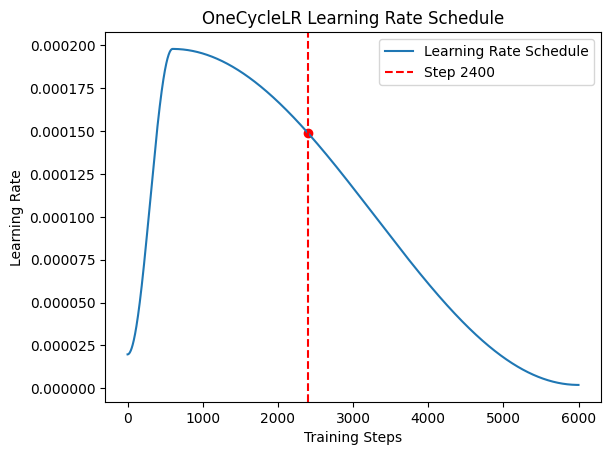

In [18]:
# scheduler values inspired from default ones in: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
# https://www.kaggle.com/code/isbhargav/guide-to-pytorch-learning-rate-scheduling
num_training_samples = len(aux_train_tabular_scaled)
num_steps_per_epoch = num_training_samples // Config.batch_size
num_training_steps = num_steps_per_epoch * Config.epochs

# found these to work well
def get_lr_scheduler(optimizer):
    if Config.lr_abalation_test:
        return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda epoch: 1e-3)

    return torch.optim.lr_scheduler.OneCycleLR(
      optimizer=optimizer,
      max_lr=Config.lr_max,
      epochs=Config.epochs,  # Specify the number of epochs
      steps_per_epoch=num_steps_per_epoch,  # Specify the number of steps per epoch
      pct_start=0.1,
      anneal_strategy='cos',
      div_factor=10,
      final_div_factor=10,
    )

lf = nn.SmoothL1Loss()  # r2_loss function

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=Config.lr_max,
    weight_decay=Config.weight_decay,
)

lr_scheduler = get_lr_scheduler(optimizer)
lrs = []
mock_lr_scheduler = get_lr_scheduler(optimizer)

for step in range(num_training_steps):
    optimizer.step()
    lrs.append(optimizer.param_groups[0]['lr'])
    mock_lr_scheduler.step()

plt.plot(lrs, label='Learning Rate Schedule')
plt.axvline(x=2400, color='red', linestyle='--', label='Step 2400')
plt.scatter(2400, lrs[2400], color='red')
plt.xlabel("Training Steps")
plt.ylabel("Learning Rate")
plt.title("OneCycleLR Learning Rate Schedule")
plt.legend()
plt.show()

In [20]:
# Early stopping parameters
best_val_r2 = -float('inf')  # Initialize to negative infinity for R²
epochs_since_improvement = 0
patience = 2

In [21]:
# Initialize lists to store the loss, MAE, and R2 after each epoch for both training and validation
train_loss_values = []
train_mae_values = []
train_r2_values = []

val_loss_values = []
val_mae_values = []
val_r2_values = []

train_loss = torchmetrics.MeanMetric().to(device)
train_mae = torchmetrics.MeanAbsoluteError().to(device)
train_r2 = torchmetrics.regression.R2Score(num_outputs=Config.num_classes, multioutput='uniform_average').to(device)

val_loss = torchmetrics.MeanMetric().to(device)
val_mae = torchmetrics.MeanAbsoluteError().to(device)
val_r2 = torchmetrics.regression.R2Score(num_outputs=Config.num_classes, multioutput='uniform_average').to(device)

print("Start Training:")
for epoch in range(Config.epochs):
    model.train()

    for step, (image, tabular, true_label) in enumerate(train_dataloader):
        t_start = time.perf_counter_ns()
        image = image.to(device)
        tabular = tabular.to(device)
        true_label = true_label.to(device)
        model = model.to(device)

        y_pred = model(image, tabular)
        loss = lf(y_pred, true_label)

        loss.backward()
        optimizer.step()

        optimizer.zero_grad()

        lr_scheduler.step()

        # Update training metrics
        train_loss.update(loss)
        train_mae.update(y_pred, true_label)
        train_r2.update(y_pred, true_label)

        print(
            f'\rEPOCH {epoch + 1:02d}, {step + 1:04d}/{num_steps_per_epoch} | ' +
            f'loss: {train_loss.compute().item():.4f}, mae: {train_mae.compute().item():.4f}, r2: {train_r2.compute().item():.4f}, ' +
            f'step: {(time.perf_counter_ns() - t_start) * 1e-9:.3f}s, lr: {lr_scheduler.get_last_lr()[0]:.2e}',
            end='\n' if (step + 1) == num_steps_per_epoch else '', flush=True,
        )
        
    train_loss_values.append(train_loss.compute().item())
    train_mae_values.append(train_mae.compute().item())
    train_r2_values.append(train_r2.compute().item())

    torch.save(model.state_dict(), f"model_epoch_{epoch + 1}.pth")

    # Reset metrics for the next epoch
    train_loss.reset()
    train_mae.reset()
    train_r2.reset()

    model.eval()

    with torch.no_grad():
        for image, tabular, true_label in (validation_dataloader):
            image = image.to(device)
            tabular = tabular.to(device)
            true_label = true_label.to(device)
            y_pred = model(image, tabular)
            loss = lf(y_pred, true_label)

            val_loss.update(loss)
            val_mae.update(y_pred, true_label)
            val_r2.update(y_pred, true_label)

    print(
        f'\rEPOCH {epoch + 1:02d}, VALIDATION | ' +
        f'loss: {val_loss.compute().item():.4f}, mae: {val_mae.compute().item():.4f}, r2: {val_r2.compute().item():.4f}',
        end='\n',
    )

    val_loss_values.append(val_loss.compute().item())
    val_mae_values.append(val_mae.compute().item())
    val_r2_values.append(val_r2.compute().item())

    # Check for early stopping
    current_val_r2 = val_r2.compute().item()
    if current_val_r2 > best_val_r2:
        best_val_r2 = current_val_r2
        epochs_since_improvement = 0
        # Optionally, save the best model here
        torch.save(model.state_dict(), "best_model.pth")
    else:
        epochs_since_improvement += 1

    # If validation R² doesn't improve for 'patience' epochs, stop training
    if epochs_since_improvement >= patience:
        print(f"Early stopping triggered after {epoch + 1} epochs.")
        break

    # Reset metrics for the next epoch
    val_loss.reset()
    val_mae.reset()
    val_r2.reset()

print("Training Losses:", train_loss_values)
print("Training MAE:", train_mae_values)
print("Training R2:", train_r2_values)
print("Validation Losses:", val_loss_values)
print("Validation MAE:", val_mae_values)
print("Validation R2:", val_r2_values)

Start Training:


<ipython-input-12-3a18cc3d6cfb>:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image_sample = imageio.imread(self.image_data[index])


EPOCH 01, VALIDATION | loss: 0.2857, mae: 0.5842, r2: 0.2457
EPOCH 02, VALIDATION | loss: 0.2709, mae: 0.5592, r2: 0.2869
EPOCH 03, VALIDATION | loss: 0.2651, mae: 0.5422, r2: 0.2934
EPOCH 04, VALIDATION | loss: 0.2644, mae: 0.5468, r2: 0.3037
EPOCH 05, VALIDATION | loss: 0.2701, mae: 0.5490, r2: 0.2899
EPOCH 06, VALIDATION | loss: 0.2712, mae: 0.5488, r2: 0.2835
Early stopping triggered after 6 epochs.
Training Losses: [0.3358214199542999, 0.28518185019493103, 0.2627914845943451, 0.24481292068958282, 0.22231076657772064, 0.19865740835666656]
Training MAE: [0.660642683506012, 0.5796747803688049, 0.546125054359436, 0.5206291675567627, 0.4895067811012268, 0.45695003867149353]
Training R2: [0.10785834491252899, 0.246384859085083, 0.3093799948692322, 0.3632374405860901, 0.4300197958946228, 0.500271737575531]
Validation Losses: [0.28570663928985596, 0.2708871364593506, 0.26506170630455017, 0.2643607556819916, 0.27013781666755676, 0.2712307870388031]
Validation MAE: [0.5841913819313049, 0.55

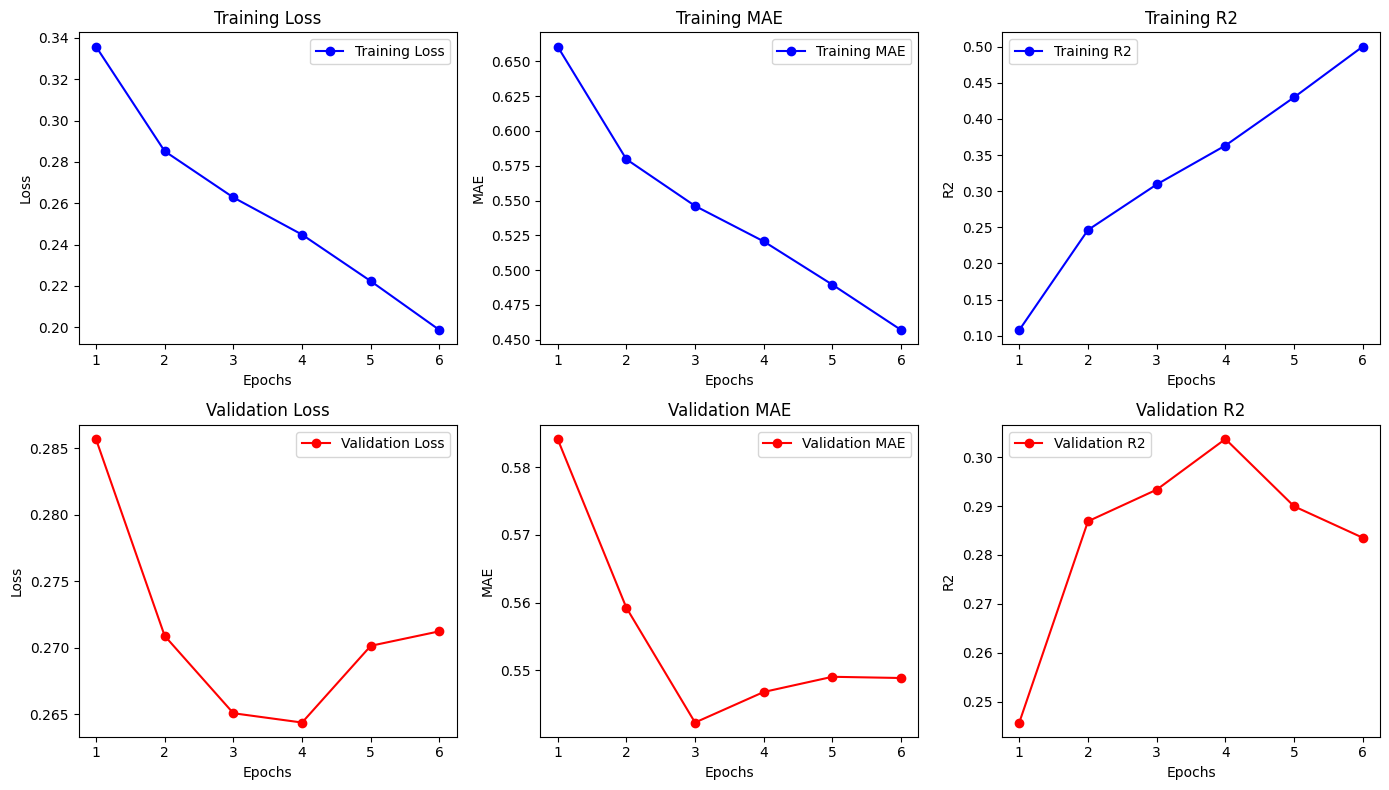

In [22]:
epochs = range(1, len(train_loss_values) + 1)

plt.figure(figsize=(14, 8))

plt.subplot(2, 3, 1)
plt.plot(epochs, train_loss_values, 'bo-', label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs, train_mae_values, 'bo-', label='Training MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Training MAE')
plt.legend()

# Plot Training R2
plt.subplot(2, 3, 3)
plt.plot(epochs, train_r2_values, 'bo-', label='Training R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.title('Training R2')
plt.legend()

plt.subplot(2, 3, 4)
plt.plot(epochs, val_loss_values, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss')
plt.legend()

plt.subplot(2, 3, 5)
plt.plot(epochs, val_mae_values, 'ro-', label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Validation MAE')
plt.legend()

plt.subplot(2, 3, 6)
plt.plot(epochs, val_r2_values, 'ro-', label='Validation R2')
plt.xlabel('Epochs')
plt.ylabel('R2')
plt.title('Validation R2')
plt.legend()

plt.tight_layout()
plt.show()

Lastly, run the model on test set and submit predictions.

In [ ]:
SUBMISSION_ROWS = []
model.eval()

for X_image, X_tabular, test_id in tqdm(test_dataloader):
    with torch.no_grad():
        y_pred = model(X_image.to(device), X_tabular.to(device)).detach().cpu().numpy()

    y_pred = Y_SCALER.inverse_transform(y_pred).squeeze()
    row = {'id': int(test_id)}

    for k, v in zip(Config.class_names, y_pred):
        if k in Config.class_names:
            row[k.replace('_mean', '')] = 10 ** v
        else:
            row[k.replace('_mean', '')] = v

    SUBMISSION_ROWS.append(row)

submission_df = pd.DataFrame(SUBMISSION_ROWS)
submission_df.to_csv('./submission.csv', index=False)
print("Submit!")

In [ ]:
!kaggle competitions submit -c cs-480-2024-spring -f submission.csv -m "Submitted"